In [1]:
#Define and move to dataset directory
datasetdir = 'F:/Datasets/doggy_dataset'
import os
os.chdir(datasetdir)

#Import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

In [3]:
#Defining two functions that we will need later.

#The first function : generators
#It returns two image iterators that we will use to produce batches of images for the training and the validation of our neural networks.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 30

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('lying','notlying'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('lying','notlying'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [4]:
#The second function will be used to plot the accuracy and loss as a function of the epoch.
#So that we can see how the training worked.
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [5]:
#Build a ResNet50 network with keras.

#Step 1 - Create our dataset iterators, with the right input shape and preprocessing functions.
resnet50 = keras.applications.resnet50
train_dataset, val_dataset = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 4312 images belonging to 2 classes.
Found 478 images belonging to 2 classes.


In [6]:
#Step 2 - Create our full model, that is the convolutional part of ResNet50 followed by our simple classifier and train it.
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

94773248/94765736 [==============================] - 429s 5us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

In [7]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=5,
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 144 steps, validate for 16 steps
Epoch 1/5
144/144 [==============================] - 1057s 7s/step - loss: 0.7424 - acc: 0.7866 - val_loss: 0.5818 - val_acc: 0.7510
Epoch 2/5
144/144 [==============================] - 934s 6s/step - loss: 0.2677 - acc: 0.8933 - val_loss: 1.0723 - val_acc: 0.6862
Epoch 3/5
144/144 [==============================] - 1669s 12s/step - loss: 0.1807 - acc: 0.9330 - val_loss: 0.7715 - val_acc: 0.7197
Epoch 4/5
144/144 [==============================] - 971s 7s/step - loss: 0.1026 - acc: 0.9666 - val_loss: 0.8347 - val_acc: 0.7364
Epoch 5/5
144/144 [==============================] - 1059s 7s/step - loss: 0.0682 - acc: 0.9754 - val_loss: 0.7517 - val_acc: 0.7531


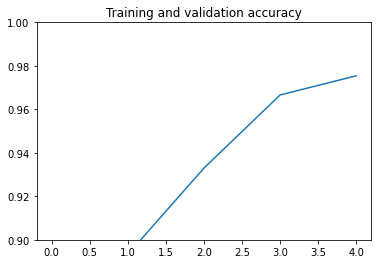

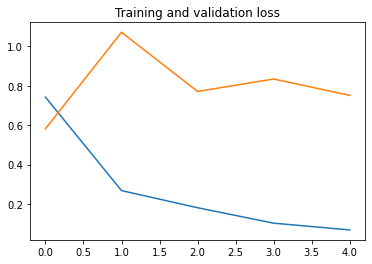

In [8]:
plot_history(history, yrange=(0.9,1))

In [9]:
#Save the model
full_model.save_weights('resnet50.h5')

In [10]:
#To read them again, we create a new model, identical to the one we have trained
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

In [11]:
#And we load the weights
full_model.load_weights('resnet50.h5')

In [12]:
#evaluating the model for all images in the training dataset
import sys

def true_and_predicted_labels(dataset):
    labels = np.zeros((dataset.n,2))
    preds = np.zeros_like(labels)
    for i in range(len(dataset)):
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
        batch = dataset[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        batch_preds = full_model.predict(batch_images)
        start = i*batch_size
        labels[start:start+batch_size] = batch_labels
        preds[start:start+batch_size] = batch_preds
    return labels, preds

train_labels, train_preds = true_and_predicted_labels(train_dataset)

In [13]:
#Illustrate how the model is able to separate the two categories : lying = 1 and notlying = 0
#Plot the lying score for the two categories :
#For lying, we expect the lying score to be close to one. For notlying, it will be close to zero.
def plot_lying_score(preds, labels, range=(0,1)):
    # get the lying score for all images
    lying_score = preds[:,1]
    # get the lying score for notlying
    # we use the true labels to select notlying images
    notlying_lying_score = lying_score[labels[:,0]>0.5]
    # and for lying
    lying_lying_score = lying_score[labels[:,0]<0.5]
    # just some plotting parameters
    params = {'bins':100, 'range':range, 'alpha':0.6}
    plt.hist(notlying_lying_score, **params)
    plt.hist(lying_lying_score, **params)
    plt.yscale('log')

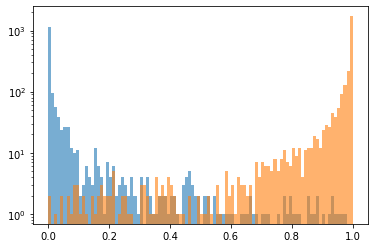

In [14]:
plot_lying_score(train_preds, train_labels)

In [15]:
#Compute accuracy

#Using lying score, we need to compute the predicted labels and compare them with the true labels.
#We decide that the network predicts lying if the lying score is larger than a given threshold.
#Keras provides an estimation of the accuraccy during the training.
#For this estimation, keras uses a threshold of 0.5
threshold = 0.5

def predicted_labels(preds, threshold):
    '''Turn predictions (floats in the last two dimensions) 
    into labels (0 or 1).'''
    pred_labels = np.zeros_like(preds)
    # lying score lower than threshold: set notlying label to 1
    # lying score higher than threshold: set notlying label to 0
    pred_labels[:,0] = preds[:,1]<threshold
    # lying score higher than threshold: set lying label to 1
    # lying score lower than threshold: set lying label to 0
    pred_labels[:,1] = preds[:,1]>=threshold
    return pred_labels

train_pred_labels = predicted_labels(train_preds, threshold)
print('predicted labels:')
print(train_pred_labels)
print('true labels:')
print(train_labels)

predicted labels:
[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
true labels:
[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [16]:
#It seems that the predicted labels are very similar to the true labels.
#This is because the accuracy is close to 100%, and only a few examples are shown in the printout above.
#Let's quantify the fraction of misclassified examples:
def misclassified(labels, pred_labels, print_report=True):
    def report(categ, n_misclassified, n_examples): 
        print('{:<4} {:>3} misclassified samples ({:4.2f}%)'.format(
            categ,
            n_misclassified, 
            100*(1-float(n_misclassified)/n_examples))
        )
    # total number of examples
    n_examples = len(labels)
    # total number of lying
    n_lying = sum(labels[:,0])
    # total number of notlying
    n_notlying = sum(labels[:,1])
    # boolean mask for misidentified examples
    mask_all = pred_labels[:,0] != labels[:,0]
    # boolean mask for misidentified lying    
    mask_lying = np.logical_and(mask_all,labels[:,1]>0.5)
    # boolean mask for misidentified notlying    
    mask_notlying = np.logical_and(mask_all,labels[:,1]<0.5)
    if print_report:
        report('all', sum(mask_all), n_examples)
        report('lying', sum(mask_lying), n_lying)
        report('notlying', sum(mask_notlying), n_notlying)
    return mask_all, mask_lying, mask_notlying

_ = misclassified(train_labels, train_pred_labels)

all  126 misclassified samples (97.08%)
lying  81 misclassified samples (95.02%)
notlying  45 misclassified samples (98.32%)


In [17]:
#Validation dataset
val_labels, val_preds = true_and_predicted_labels(val_dataset)
val_pred_labels = predicted_labels(val_preds, threshold)
_ = misclassified(val_labels, val_pred_labels)

all  114 misclassified samples (76.15%)
lying  35 misclassified samples (80.56%)
notlying  79 misclassified samples (73.49%)
